In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import seaborn as sns
%matplotlib inline

In [201]:
df_votes = pd.read_csv('../propublica/toyset.csv')
df_cosponsors = pd.read_csv('../propublica/member_votes_bills_cosponsors.csv')
with open('../campaign_contributions/open_secrets/processed/cosign_all_industries.pickle', 'rb') as f:
    contributions = pickle.load(f)
df_votes = pd.merge(df_votes, df_cosponsors, how = 'left', on = 'bill_id')
df_votes = df_votes.dropna(subset = ['cosponsor_ids'])

In [202]:
def sponsor_cosign(row, span):
    """Looks up the cosign similarity between the member and the sponsor"""
    try:
        if row.bill_type == 's':
            body = 'senate'
        else:
            body = 'house'
        cong_n = int(row.congress)
        members = (row.id, row.sponsor_id_y)
        
        cosign = contributions[body][cong_n][span][members]
        return cosign
    except:
        return np.nan

def cs_same_party(row):
    """Calculates the percentage of cosponsors that are of same party"""
    try:
        cs_parties = eval(row.cosponsors_by_party)
        mem_party = row.party
        numerator = 0
        if cs_parties:
            for party in cs_parties:
                if party['party']['id'] == mem_party:
                    numerator = party['party']['sponsors']
            return int(numerator) / int(row.number_of_cosponsors)
        else:
            return 0
    except:
        return np.nan

def cosponsor_cosign(row, span):
    """Get central tendency stats of cosign similarities between cosponsors and member"""
    cosponsors = eval(row.cosponsor_ids)
    
    if cosponsors:
        cosponsors.append(row.sponsor_id_y)
    else:
        cosponsors = [row.sponsor_id_y]
    
    cosigns = []
    for cosponsor in cosponsors:
        try:
            if row.bill_type == 's':
                body = 'senate'
            else:
                body = 'house'
            cong_n = int(row.congress)
            members = (row.id, cosponsor)

            cosign = contributions[body][cong_n][span][members]
        except:
            cosign = np.nan
        cosigns.append(cosign)
    stats = pd.Series(cosigns).describe().to_dict()
    if pd.isnull(stats['std']):
        stats['std'] = 0
    return stats

def is_sponsor(row):
    """check if member sponsored or cosponsored bill"""
    if row.id == row.sponsor_id_y:
        return 1
    elif row.id in eval(row.cosponsor_ids):
        return 1
    else:
        return 0

In [203]:
df_votes['sponsor_cs_current'] = df_votes.apply(sponsor_cosign, span = 'current', axis = 1)
df_votes['sponsor_cs_p3'] = df_votes.apply(sponsor_cosign, span = 'p3', axis = 1)
df_votes['sponsor_same_party'] = df_votes.party == df_votes.sponsor_party
df_votes['cosponsor_same_party'] = df_votes.apply(cs_same_party, axis =1)
for span in ['p3', 'current']:
    df_cosponsor_cosign = df_votes.apply(cosponsor_cosign, span = span, axis = 1)
    df_cosponsor_cosign = pd.DataFrame(df_cosponsor_cosign.tolist(), index=df_cosponsor_cosign.index)
    df_cosponsor_cosign.columns = ["cs_" + span + "_" + x for x in df_cosponsor_cosign.columns]
    df_votes = pd.concat([df_votes, df_cosponsor_cosign], axis = 1)
df_votes['is_sponsor'] = df_votes.apply(is_sponsor, axis = 1)

In [204]:
df_votes.head()

,id,bill_id,date,party,voted_against_party,position,sponsor_id_x,source,bill_slug,bill_type,congress,cosponsor_ids,cosponsors_by_party,house_passage_vote,introduced_date,number_of_cosponsors,sponsor_id_y,sponsor_party,sponsor_cs_current,sponsor_cs_p3,sponsor_same_party,cosponsor_same_party,cs_p3_25%,cs_p3_50%,cs_p3_75%,cs_p3_count,cs_p3_max,cs_p3_mean,cs_p3_min,cs_p3_std,cs_current_25%,cs_current_50%,cs_current_75%,cs_current_count,cs_current_max,cs_current_mean,cs_current_min,cs_current_std
0,F000460,hres601-115,2017-11-02,R,0,Yes,B001248,Train,hres601,hres,115.0,[],[],2017-11-02,2017-11-01,0.0,B001248,R,0.894840,0.795151,True,0.000000,0.795151,0.795151,0.795151,1.0,0.795151,0.795151,0.795151,0.000000,0.894840,0.894840,0.894840,1.0,0.894840,0.894840,0.894840,0.000000
1,A000366,hr6443-112,2012-12-20,R,0,Yes,W000797,Train,hr6443,hr,112.0,"['D000610', 'W000808', 'B000911', 'H000324', '...","[{'party': {'id': 'D', 'sponsors': '5'}}, {'pa...",2012-12-20,2012-09-19,24.0,W000797,D,NaN,NaN,False,0.791667,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000
2,M001163,hr3043-115,2017-11-08,D,0,Yes,M001159,Train,hr3043,hr,115.0,[],[],2017-11-08,2017-06-23,0.0,M001159,R,0.682422,0.613091,False,0.000000,0.613091,0.613091,0.613091,1.0,0.613091,0.613091,0.613091,0.000000,0.682422,0.682422,0.682422,1.0,0.682422,0.682422,0.682422,0.000000
4,M001177,hr1066-115,2017-11-06,R,0,Yes,K000381,Train,hr1066,hr,115.0,"['N000189', 'K000382', 'R000586', 'B001284', '...","[{'party': {'id': 'D', 'sponsors': '4'}}, {'pa...",2017-11-06,2017-02-15,10.0,K000381,D,0.243556,0.331429,False,0.600000,0.290205,0.347987,0.713559,11.0,0.905337,0.494583,0.248274,0.249574,0.242376,0.307674,0.457873,11.0,0.861923,0.361851,0.065824,0.215294
5,L000567,hres607-115,2017-11-07,R,0,Yes,B001289,Train,hres607,hres,115.0,[],[],2017-11-07,2017-11-06,0.0,B001289,R,0.765137,0.773235,True,0.000000,0.773235,0.773235,0.773235,1.0,0.773235,0.773235,0.773235,0.000000,0.765137,0.765137,0.765137,1.0,0.765137,0.765137,0.765137,0.000000


In [205]:
df_votes.columns

Index(['id', 'bill_id', 'date', 'party', 'voted_against_party', 'position',
       'sponsor_id_x', 'source', 'bill_slug', 'bill_type', 'congress',
       'cosponsor_ids', 'cosponsors_by_party', 'house_passage_vote',
       'introduced_date', 'number_of_cosponsors', 'sponsor_id_y',
       'sponsor_party', 'sponsor_cs_current', 'sponsor_cs_p3',
       'sponsor_same_party', 'cosponsor_same_party', 'cs_p3_25%', 'cs_p3_50%',
       'cs_p3_75%', 'cs_p3_count', 'cs_p3_max', 'cs_p3_mean', 'cs_p3_min',
       'cs_p3_std', 'cs_current_25%', 'cs_current_50%', 'cs_current_75%',
       'cs_current_count', 'cs_current_max', 'cs_current_mean',
       'cs_current_min', 'cs_current_std'],
      dtype='object')

In [239]:
columns = ['voted_against_party','source','sponsor_same_party',
           'sponsor_cs_current','sponsor_cs_p3', 'number_of_cosponsors',
           'cosponsor_same_party', 'is_sponsor']
columns += [x for x in df_votes.columns if x.startswith('cs_')]
df_model = df_votes[columns]
df_model.dropna(inplace=True)
df_model.reset_index(inplace = True, drop=True)

C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [240]:
columns = ['sponsor_cs_current','sponsor_cs_p3']
interactions = df_model[columns].mul(df_model.sponsor_same_party, axis = 0)
df_model = pd.concat([df_model, interactions], axis = 1)

columns = [x for x in df_votes.columns if x.startswith('cs_')]
interactions = df_model[columns].mul(df_model.cosponsor_same_party, axis = 0)
df_model = pd.concat([df_model, interactions], axis = 1)

In [216]:
df_model.head()

,voted_against_party,source,sponsor_same_party,sponsor_cs_current,sponsor_cs_p3,number_of_cosponsors,cosponsor_same_party,cs_p3_25%,cs_p3_50%,cs_p3_75%,cs_p3_count,cs_p3_max,cs_p3_mean,cs_p3_min,cs_p3_std,cs_current_25%,cs_current_50%,cs_current_75%,cs_current_count,cs_current_max,cs_current_mean,cs_current_min,cs_current_std,sponsor_cs_current,sponsor_cs_p3,cs_p3_25%,cs_p3_50%,cs_p3_75%,cs_p3_count,cs_p3_max,cs_p3_mean,cs_p3_min,cs_p3_std,cs_current_25%,cs_current_50%,cs_current_75%,cs_current_count,cs_current_max,cs_current_mean,cs_current_min,cs_current_std
0,0,Train,True,0.894840,0.795151,0.0,0.0,0.795151,0.795151,0.795151,1.0,0.795151,0.795151,0.795151,0.000000,0.894840,0.894840,0.894840,1.0,0.894840,0.894840,0.894840,0.000000,0.894840,0.795151,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0,Train,False,0.682422,0.613091,0.0,0.0,0.613091,0.613091,0.613091,1.0,0.613091,0.613091,0.613091,0.000000,0.682422,0.682422,0.682422,1.0,0.682422,0.682422,0.682422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0,Train,False,0.243556,0.331429,10.0,0.6,0.290205,0.347987,0.713559,11.0,0.905337,0.494583,0.248274,0.249574,0.242376,0.307674,0.457873,11.0,0.861923,0.361851,0.065824,0.215294,0.000000,0.000000,0.174123,0.208792,0.428136,6.6,0.543202,0.29675,0.148964,0.149745,0.145425,0.184604,0.274724,6.6,0.517154,0.217111,0.039494,0.129177
3,0,Train,True,0.765137,0.773235,0.0,0.0,0.773235,0.773235,0.773235,1.0,0.773235,0.773235,0.773235,0.000000,0.765137,0.765137,0.765137,1.0,0.765137,0.765137,0.765137,0.000000,0.765137,0.773235,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0,Train,True,0.848394,0.860215,1.0,0.0,0.663887,0.729330,0.794772,2.0,0.860215,0.729330,0.598445,0.185099,0.707406,0.754402,0.801398,2.0,0.848394,0.754402,0.660410,0.132925,0.848394,0.860215,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [241]:
drop = ['voted_against_party','source']
columns = [x for x in df_model.columns if x not in drop]
lgr = LogisticRegression()
x_train = df_model.loc[df_model.source == 'Train', columns]

In [242]:
drop = ['voted_against_party','source']
columns = [x for x in df_model.columns if x not in drop]
lgr = LogisticRegression()
x_train = df_model.loc[df_model.source == 'Train', columns]
y_train = df_model[df_model.source == 'Train'].voted_against_party
x_test = df_model.loc[df_model.source == 'Test', columns]
y_test = df_model[df_model.source == 'Test'].voted_against_party

lgr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [254]:
18000/160000000

0.0001125

In [243]:
# baseline
print(metrics.classification_report(y_test, np.zeros(len(y_test))))

             precision    recall  f1-score   support

          0       0.83      1.00      0.91      1535
          1       0.00      0.00      0.00       321

avg / total       0.68      0.83      0.75      1856



C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [244]:
print(metrics.classification_report(y_test, lgr.predict(x_test)))

             precision    recall  f1-score   support

          0       0.85      0.96      0.90      1535
          1       0.48      0.17      0.25       321

avg / total       0.78      0.82      0.79      1856



In [245]:
probs = lgr.predict_proba(x_train)[:,1]
cuts = [np.percentile(probs,x) for x in np.linspace(20,100,20)]
f1 = []
for threshold in cuts:
    pred = probs >= threshold
    f1.append([threshold, metrics.f1_score(y_train,pred, average='weighted')])
f1 = pd.DataFrame(f1, columns=['threshold','f1'])
threshold = f1.threshold[f1.f1.idxmax()]
p = lgr.predict_proba(x_test)[:,1] > threshold
print(metrics.classification_report(y_test, p))

             precision    recall  f1-score   support

          0       0.88      0.88      0.88      1535
          1       0.42      0.42      0.42       321

avg / total       0.80      0.80      0.80      1856



In [247]:
threshold

0.28255694349691268

In [229]:
probs = lgr.predict_proba(x_test)[:,1]

In [234]:
probs.min()

0.00044477446007927529

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


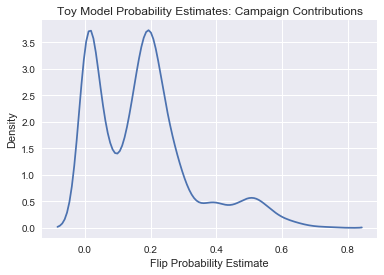

In [253]:
ax = sns.distplot(probs, hist=False)
ax.set(ylabel='Density',xlabel = "Flip Probability Estimate", 
       title = 'Toy Model Probability Estimates: Campaign Contributions')
ax.figure.savefig("prop_estimates.jpg")

In [61]:
y_test = df_votes[df_votes.source == 'Test'].voted_against_party
print(metrics.classification_report(y_test, [0] * len(y_test)))

             precision    recall  f1-score   support

          0       0.82      1.00      0.90      2273
          1       0.00      0.00      0.00       503

avg / total       0.67      0.82      0.74      2776



C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
columns = ['voted_against_party','source','sponsor_same_party',
           'sponsor_cs_current','sponsor_cs_p3']
df_model = df_votes[columns]
df_model.dropna(inplace=True)
df_model.reset_index(inplace = True, drop=True)

C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [74]:
df_model

,index,voted_against_party,source,sponsor_same_party,sponsor_cs_current,sponsor_cs_p3
0,0,0,Train,True,0.894840,0.795151
1,2,0,Train,False,0.682422,0.613091
2,4,0,Train,False,0.243556,0.331429
3,5,0,Train,True,0.765137,0.773235
4,6,0,Train,True,0.848394,0.860215
5,8,0,Train,False,0.163571,0.375138
6,14,0,Train,False,0.726237,0.609512
7,15,0,Train,True,0.868371,0.737725
8,16,0,Train,False,0.468702,0.530630
9,17,1,Train,True,0.788900,0.853579


In [75]:
columns = ['sponsor_same_party','sponsor_cs_current','sponsor_cs_p3']
poly = PolynomialFeatures(interaction_only=True)
test = poly.fit_transform(df_model[columns])

In [87]:
lgr = LogisticRegression()
x_train = pd.DataFrame(test)[df_model.source == 'Train']
y_train = df_model[df_model.source == 'Train'].voted_against_party
x_test = pd.DataFrame(test)[df_model.source == 'Test']
y_test = df_model[df_model.source == 'Test'].voted_against_party

lgr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [112]:
probs = lgr.predict_proba(x_train)[:,1]
cuts = [np.percentile(probs,x) for x in np.linspace(50,100,9)]
f1 = []
for threshold in cuts:
    pred = probs >= threshold
    f1.append([threshold, metrics.f1_score(y_train,pred, average='weighted')])
f1 = pd.DataFrame(f1, columns=['threshold','f1'])
threshold = f1.threshold[f1.f1.idxmax()]
p = lgr.predict_proba(x_test)[:,1] > threshold
print(metrics.classification_report(y_test, p))

             precision    recall  f1-score   support

          0       0.83      0.94      0.88      1535
          1       0.19      0.07      0.10       321

avg / total       0.72      0.79      0.75      1856



In [104]:
print(metrics.classification_report(y_test, [0] * len(y_test)))

             precision    recall  f1-score   support

          0       0.83      1.00      0.91      1535
          1       0.00      0.00      0.00       321

avg / total       0.68      0.83      0.75      1856



C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [121]:
r = results.predict(df_model[df_model.source == 'Test'])

In [129]:
p = r > .35
print(metrics.classification_report(y_test, p))

             precision    recall  f1-score   support

          0       0.83      1.00      0.90      1535
          1       0.29      0.01      0.01       321

avg / total       0.73      0.83      0.75      1856



In [118]:
results = smf.logit('voted_against_party ~ sponsor_same_party + sponsor_cs_current + sponsor_cs_p3 + sponsor_cs_p3 * sponsor_same_party + sponsor_cs_current * sponsor_same_party' , data = df_model[df_model.source == 'Train']).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.459527
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     voted_against_party   No. Observations:                 5565
Model:                           Logit   Df Residuals:                     5559
Method:                            MLE   Df Model:                            5
Date:                 Mon, 13 Nov 2017   Pseudo R-squ.:                 0.01677
Time:                         02:07:34   Log-Likelihood:                -2557.3
converged:                        True   LL-Null:                       -2600.9
                                         LLR p-value:                 2.561e-17
                                                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------------
Intercept                     

In [115]:
df_model.columns

Index(['index', 'voted_against_party', 'source', 'sponsor_same_party',
       'sponsor_cs_current', 'sponsor_cs_p3'],
      dtype='object')

In [103]:
threshold

0.22142667461828827

In [108]:
np.linspace(50,90,9)

array([ 50.,  55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.])

In [111]:
np.percentile(probs,90)

0.22142667461828827

In [132]:
probs.min()

0.070284286175330946

In [131]:
probs.max()

0.32768386731992205

In [71]:
test

PolynomialFeatures(degree=      sponsor_same_party  sponsor_cs_current  sponsor_cs_p3
0                   True            0.894840       0.795151
1                  False                 NaN            NaN
2                  False            0.682422       0.613091
4                  False            0.243556       0....      0.751188
18024               True            0.620365       0.610913

[11137 rows x 3 columns],
          include_bias=True, interaction_only=True)

In [30]:
df_votes.bill_type.unique()

array(['hr', 'hres', 'hjres', 's'], dtype=object)